In [1]:
import sqlite3 as sql
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import json


In [2]:
conn = sql.connect(r'C:\Users\ajk51\Desktop\Lichess Analysis\Lichess-Data-Analysis\lichess game data.db')
cur = conn.cursor()

# Exploratory Analysis

In [7]:
match_types = dict(cur.execute('''SELECT COUNT (game_id), game_type 
                    FROM games_metadata
                    GROUP BY game_type''').fetchall())


Text(0.5, 1.0, 'Distribution of Game Types')

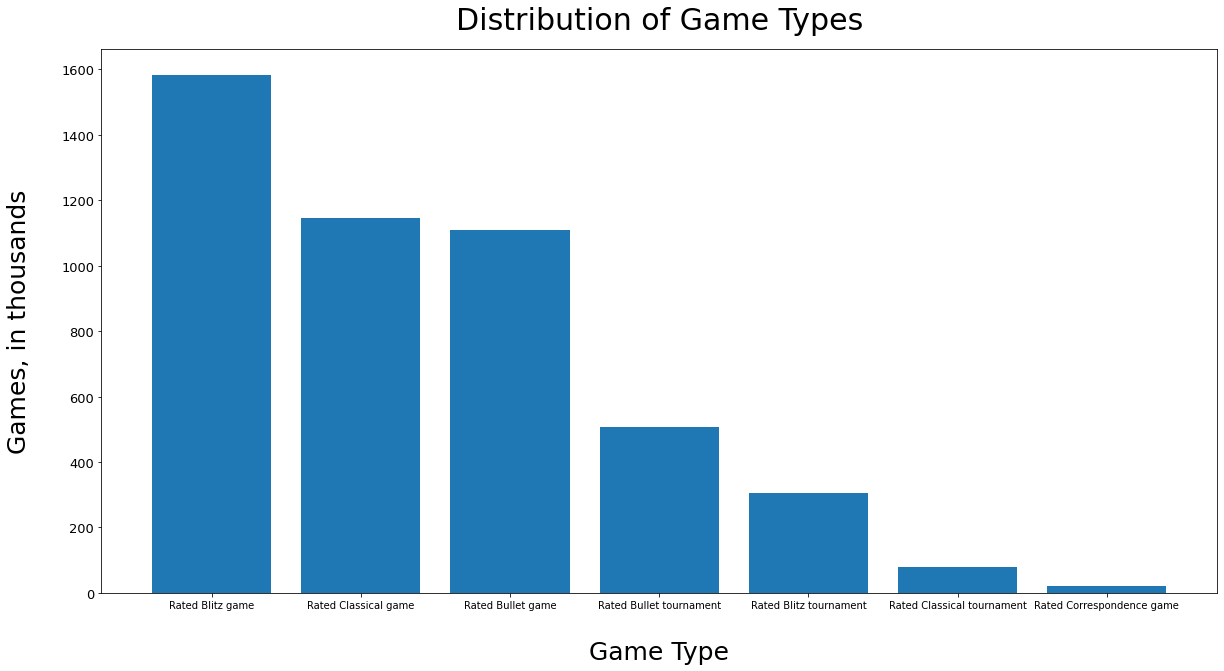

In [8]:
labels = []
for num in sorted(match_types.keys(), reverse=True):
    labels.append(match_types[num])

values = list(map(lambda x : x/1000, sorted(match_types.keys(), reverse=True)))

plt.figure(figsize=(20,10))
plt.bar(x=labels, height= values)

plt.xlabel('Game Type', fontsize=25, labelpad=30)
plt.xticks(fontsize=10)

plt.ylabel('Games, in thousands', fontsize=25, labelpad=30)
plt.yticks(fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Distribution of Game Types', fontsize=30, pad=20)



In [61]:
win_breakdown = dict(cur.execute('''SELECT COUNT (game_id), winner 
                    FROM games_metadata
                    GROUP BY winner''').fetchall())


Text(0.5, 1.0, 'Who Wins, by Games')

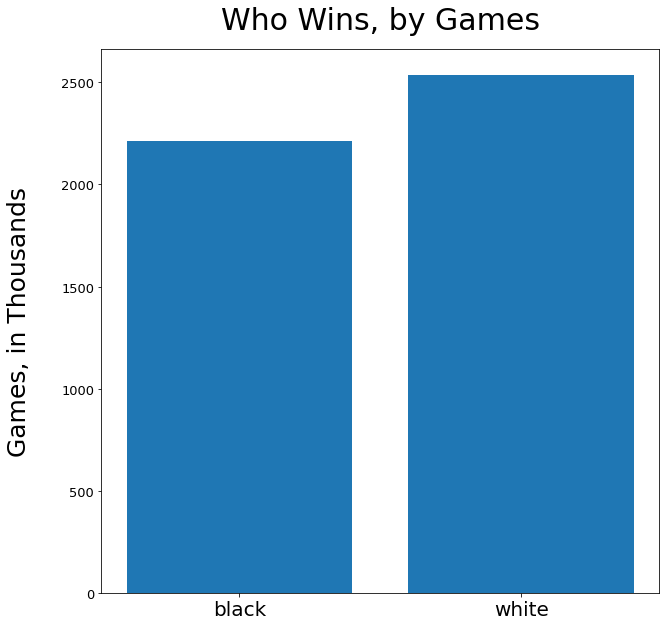

In [92]:
win_values = list(map(lambda x: x/1000, win_breakdown.keys()))

win_labels = win_breakdown.values()

plt.figure(figsize=(10,10))
plt.bar(x=win_labels, height= win_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Who Wins, by Games', fontsize=30, pad=20)


Text(0.5, 1.0, 'Who Wins, by Percent')

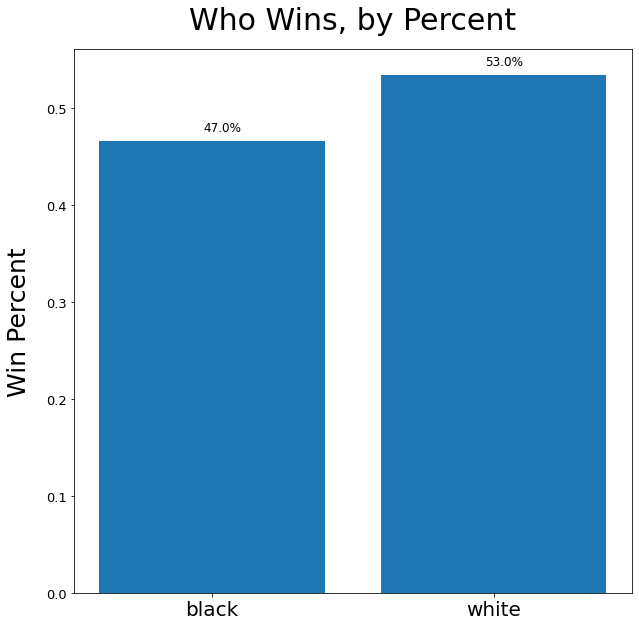

In [93]:
win_percent = {'black':list(win_breakdown.keys())[0] / sum(win_breakdown.keys()),
              'white': list(win_breakdown.keys())[1] / sum(win_breakdown.keys())}

plt.figure(figsize=(10,10))
plt.bar(x=win_percent.keys(), height= win_percent.values())

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Win Percent', fontsize=25, labelpad=15)

for index, data in enumerate(win_percent.values()):
    plt.text(x=index-0.03, y=data+0.01, s=f"{round(data,2)*100}%", fontdict=dict(fontsize=12))

plt.ticklabel_format(style='plain', axis='y')
plt.title('Who Wins, by Percent', fontsize=30, pad=20)


In [9]:
win_type = dict(cur.execute('''SELECT COUNT (game_id), game_end 
                    FROM games_metadata
                    GROUP BY game_end''').fetchall())

Text(0.5, 1.0, 'How Games End')

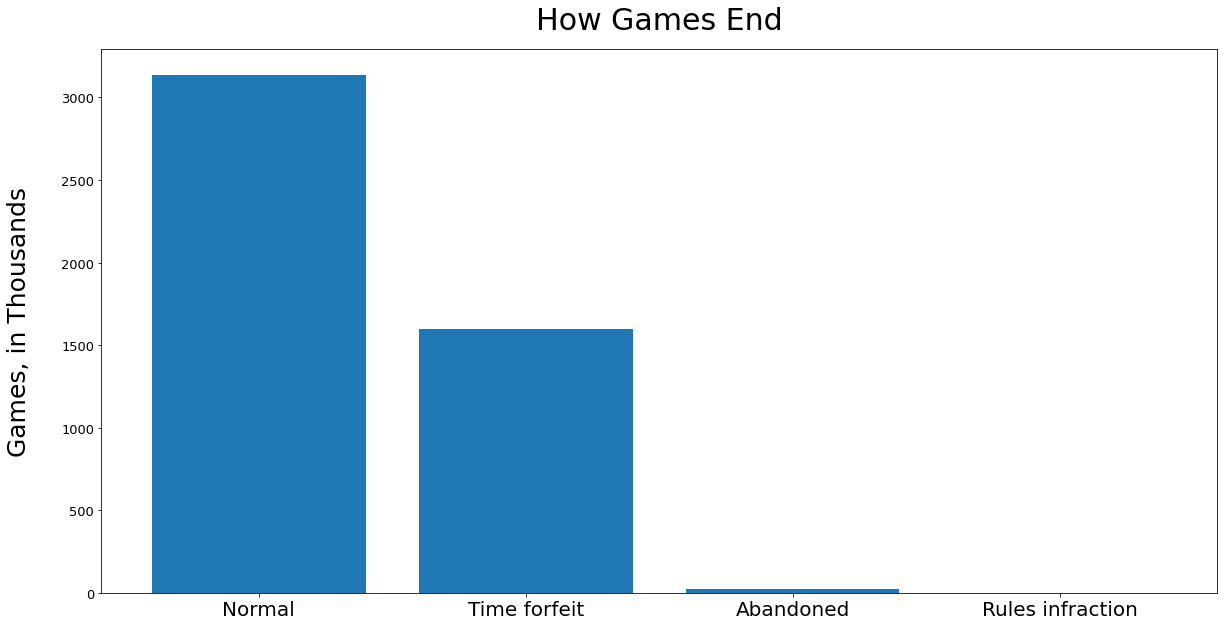

In [10]:
win_types_values = list(map(lambda x: x/1000, sorted(win_type.keys(), reverse=True)))

win_types_labels = []
for num in sorted(win_type.keys(), reverse=True):
    win_types_labels.append(win_type[num])

plt.figure(figsize=(20,10))
plt.bar(x=win_types_labels, height= win_types_values)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Games, in Thousands', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('How Games End', fontsize=30, pad=20)



In [4]:
black_elos = dict((cur.execute('''SELECT ROUND(black_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

Text(0.5, 1.0, 'Black Player Ratings')

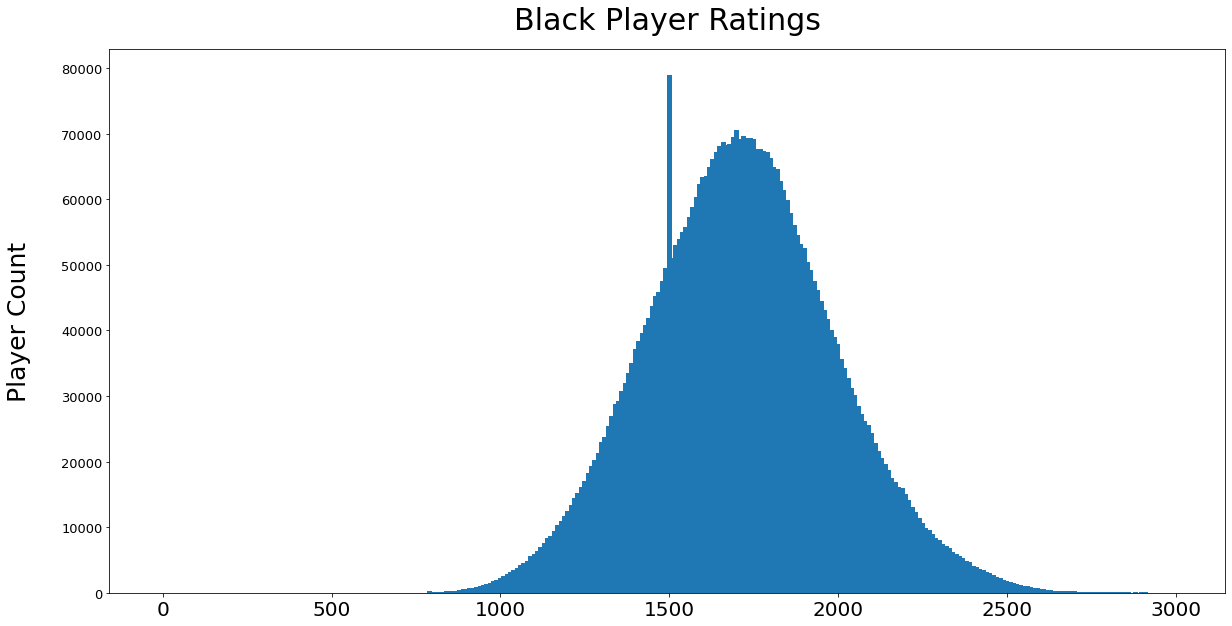

In [13]:
black_elos_values = list(black_elos.values())

black_elos_labels = list(black_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=black_elos_labels, height= black_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Player Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Black Player Ratings', fontsize=30, pad=20)


In [27]:
white_elos = dict((cur.execute('''SELECT ROUND(white_elo/10, 1)*10    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket''')).fetchall())

Text(0.5, 1.0, 'White Player Ratings')

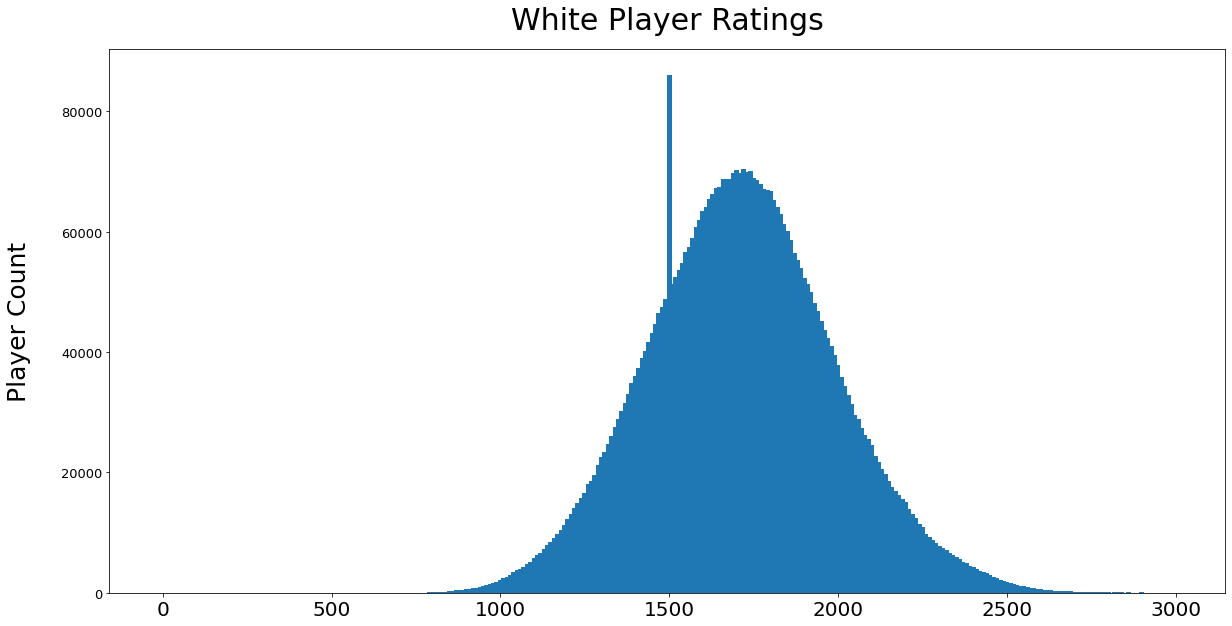

In [19]:
white_elos_values = list(white_elos.values())

white_elos_labels = list(white_elos.keys())

plt.figure(figsize=(20,10))
plt.bar(x=white_elos_labels, height= white_elos_values, width=15)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Player Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('White Player Ratings', fontsize=30, pad=20)


Text(0.5, 1.0, 'White & Black Player Ratings')

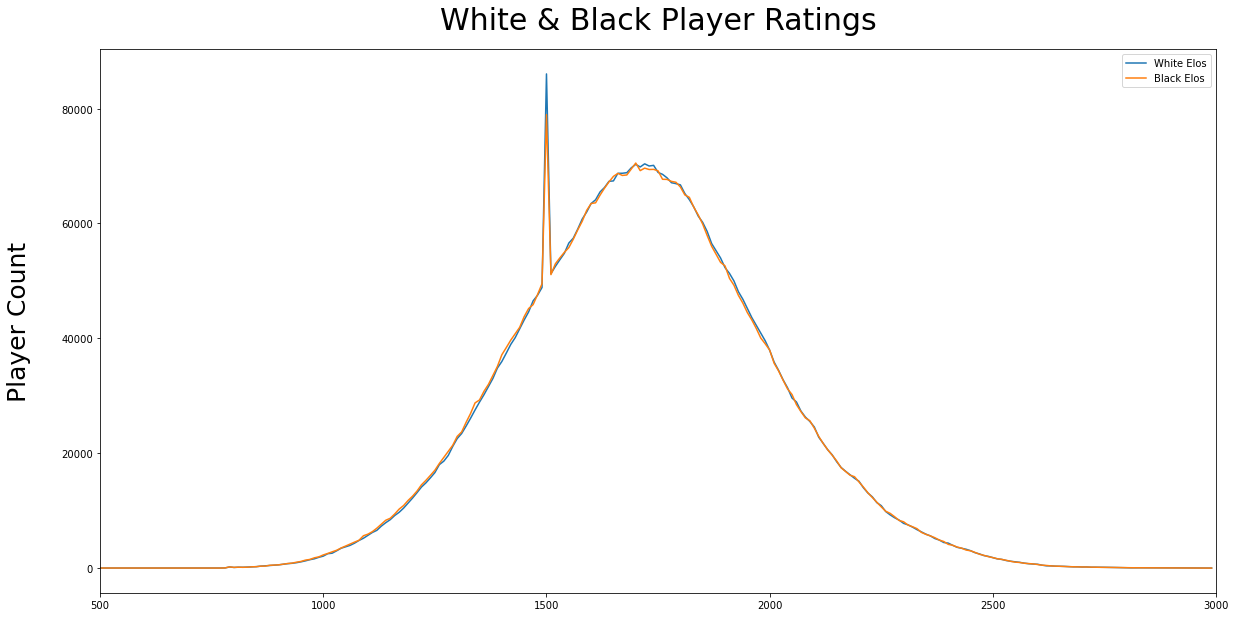

In [32]:
plt.figure(figsize=(20,10))
plt.xlim(left=500, right = 3000)

plt.plot(white_elos_labels, white_elos_values, label = 'White Elos')
plt.plot(black_elos_labels, black_elos_values, label = 'Black Elos')

plt.legend()
plt.ylabel('Player Count', fontsize=25, labelpad=30)
plt.title('White & Black Player Ratings', fontsize=30, pad=20)


In [41]:
elo_by_game_white = {}
elo_by_game_black = {}

for game_type in labels:
    elo_by_game_white[game_type] = dict((cur.execute(F'''SELECT ROUND(white_elo/10, 1)*10 AS bucket,
    COUNT(game_id) AS COUNT
    FROM games_metadata
    WHERE game_type = '{game_type}'
    GROUP BY bucket;''')).fetchall())
    
    elo_by_game_black[game_type] = dict((cur.execute(F'''SELECT ROUND(black_elo/10, 1)*10 AS bucket,
    COUNT(game_id) AS COUNT
    FROM games_metadata
    WHERE game_type = '{game_type}'
    GROUP BY bucket;''')).fetchall())


Text(0.5, 1.0, 'Ratings By Game Style (White Player)')

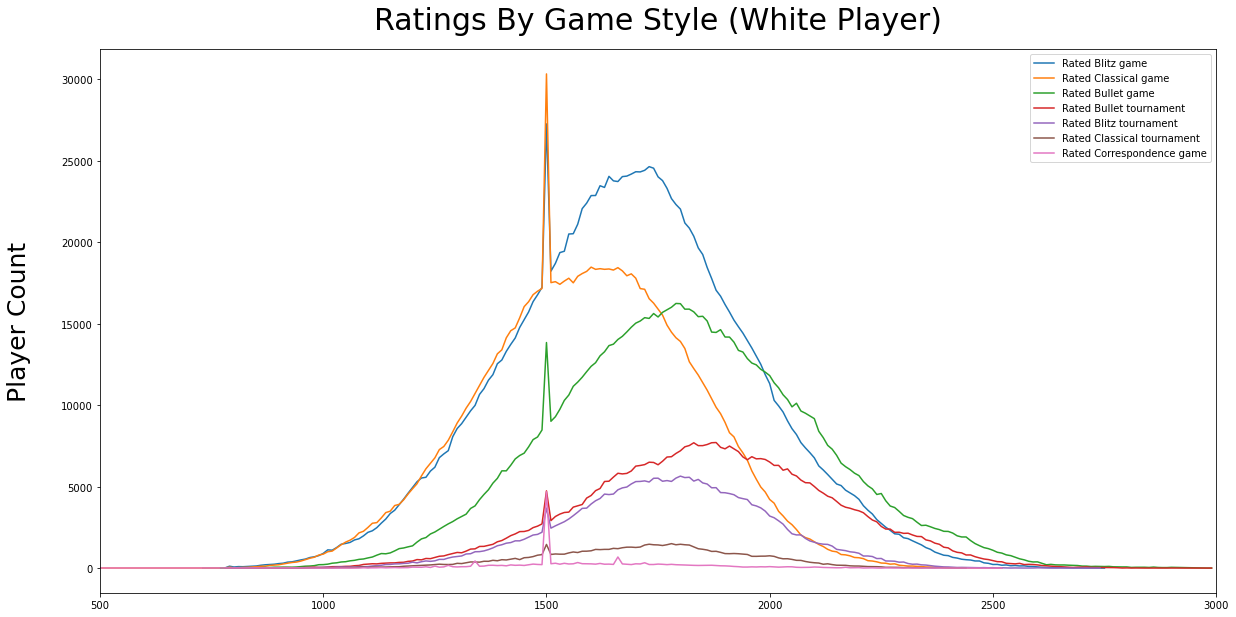

In [42]:
plt.figure(figsize=(20,10))
plt.xlim(left=500, right = 3000)

for game_type in elo_by_game_white.keys():
      plt.plot(elo_by_game_white[game_type].keys(), elo_by_game_white[game_type].values(), label = game_type)
        
plt.legend()
plt.ylabel('Player Count', fontsize=25, labelpad=30)
plt.title('Ratings By Game Style (White Player)', fontsize=30, pad=20)


Text(0.5, 1.0, 'Ratings By Game Style (Black Player)')

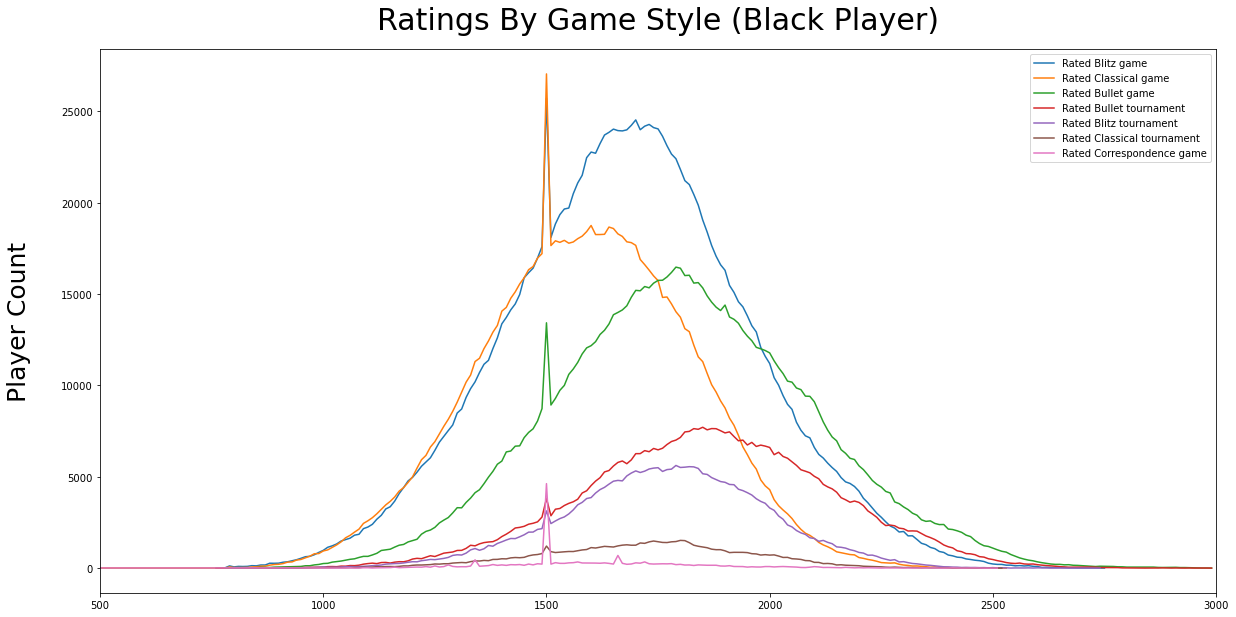

In [43]:
plt.figure(figsize=(20,10))
plt.xlim(left=500, right = 3000)

for game_type in elo_by_game_black.keys():
      plt.plot(elo_by_game_black[game_type].keys(), elo_by_game_black[game_type].values(), label = game_type)
        
plt.legend()
plt.ylabel('Player Count', fontsize=25, labelpad=30)
plt.title('Ratings By Game Style (Black Player)', fontsize=30, pad=20)


In [21]:
white_rated_white_win = {}
white_rated_black_win = {}
black_rated_black_win = {}
black_rated_white_win = {}

for x in range (800, 2050, 50):
    
    #White rated as x and wins
    white_rated_white_win[str(x)] = cur.execute(F'''SELECT (cast(sum(white_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'white' THEN 1
            ELSE 0
            END white_winner
        FROM games_metadata
        WHERE white_elo ={x})''').fetchone()[0]
    
    #White rated as x and loses
    white_rated_black_win[str(x)] = cur.execute(F'''SELECT (cast(sum(black_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'black' THEN 1
            ELSE 0
            END black_winner
        FROM games_metadata
        WHERE white_elo ={x})''').fetchone()[0]
    
    #Black rated as x and wins
    black_rated_black_win[str(x)] = cur.execute(F'''SELECT (cast(sum(black_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'black' THEN 1
            ELSE 0
            END black_winner
        FROM games_metadata
        WHERE black_elo ={x})''').fetchone()[0]
    
    #Black rated as x and loses
    black_rated_white_win[str(x)] = cur.execute(F'''SELECT (cast(sum(white_winner) AS REAL) / count(game_id)) AS win_rate
    FROM(
        SELECT game_id, 
            CASE WHEN winner = 'white' THEN 1
            ELSE 0
            END white_winner
        FROM games_metadata
        WHERE black_elo ={x})''').fetchone()[0]

Text(0.5, 1.0, 'Win %, White Rated as X')

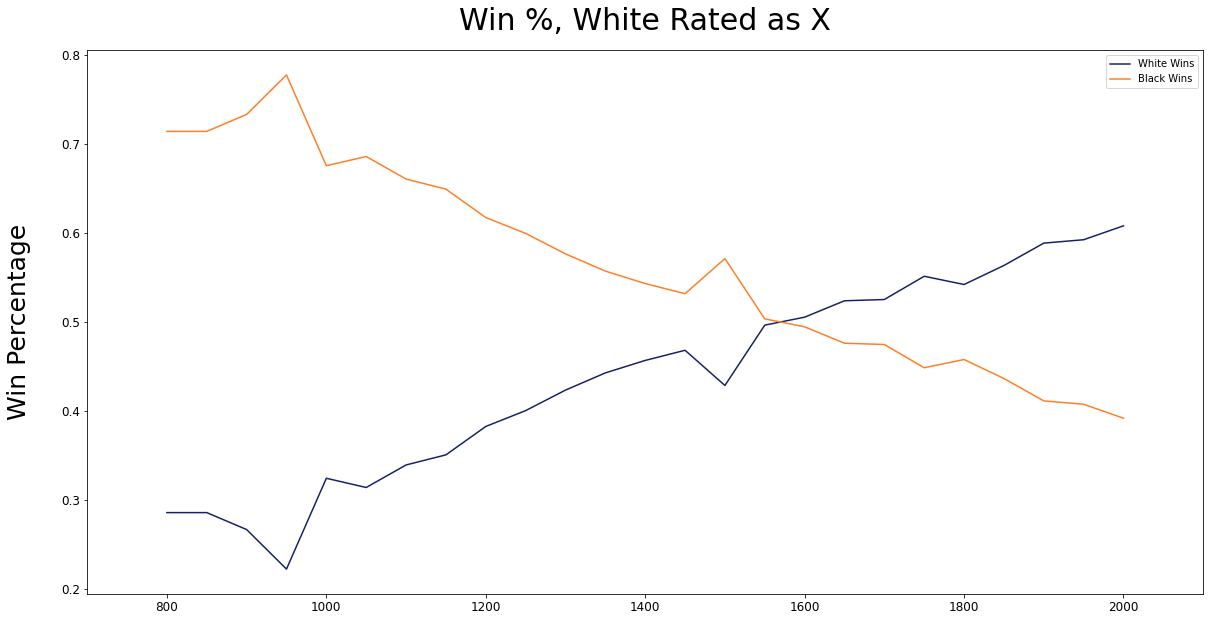

In [56]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

labels = list(map(int, white_rated_white_win.keys()))

plt.plot(labels, white_rated_white_win.values(), label='White Wins', color="#162166")
plt.plot(labels, white_rated_black_win.values(), label='Black Wins', color = '#ff7f26')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Win Percentage', fontsize=25, labelpad=30)
plt.title('Win %, White Rated as X', fontsize=30, pad=20)


Text(0.5, 1.0, 'Win %, Black Rated as X')

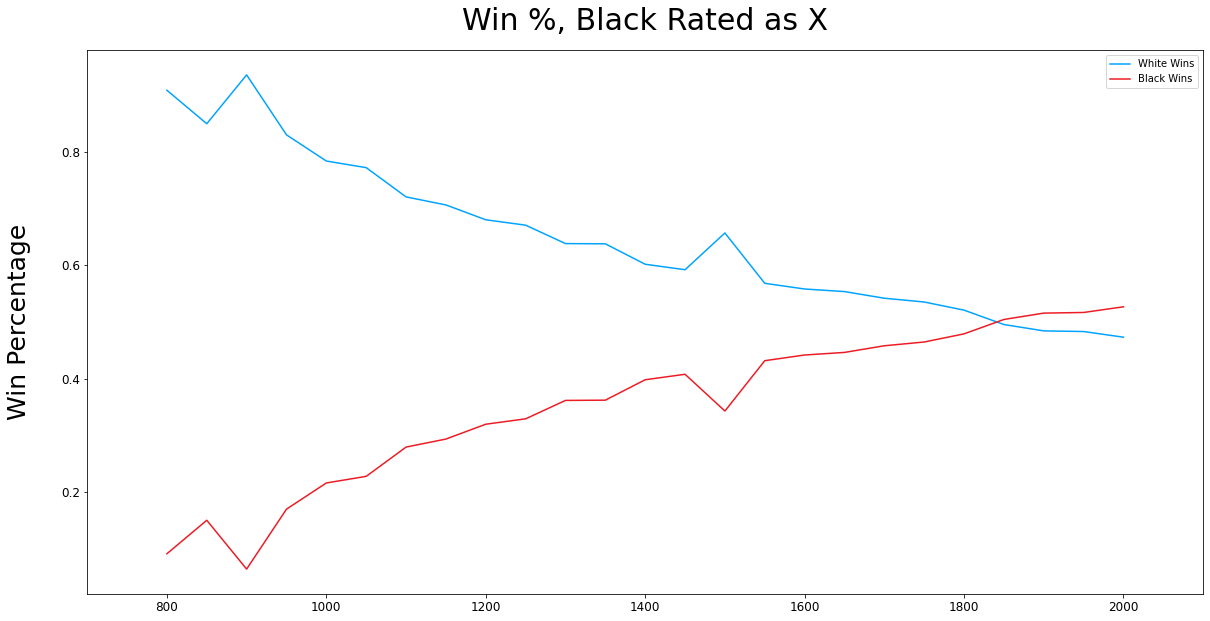

In [57]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

labels = list(map(int, black_rated_white_win.keys()))

plt.plot(labels, black_rated_white_win.values(), label='White Wins', color='#00a3ff')
plt.plot(labels, black_rated_black_win.values(), label='Black Wins', color='#ed1b24')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Win Percentage', fontsize=25, labelpad=30)
plt.title('Win %, Black Rated as X', fontsize=30, pad=20)

Text(0.5, 1.0, 'Win % Comparison')

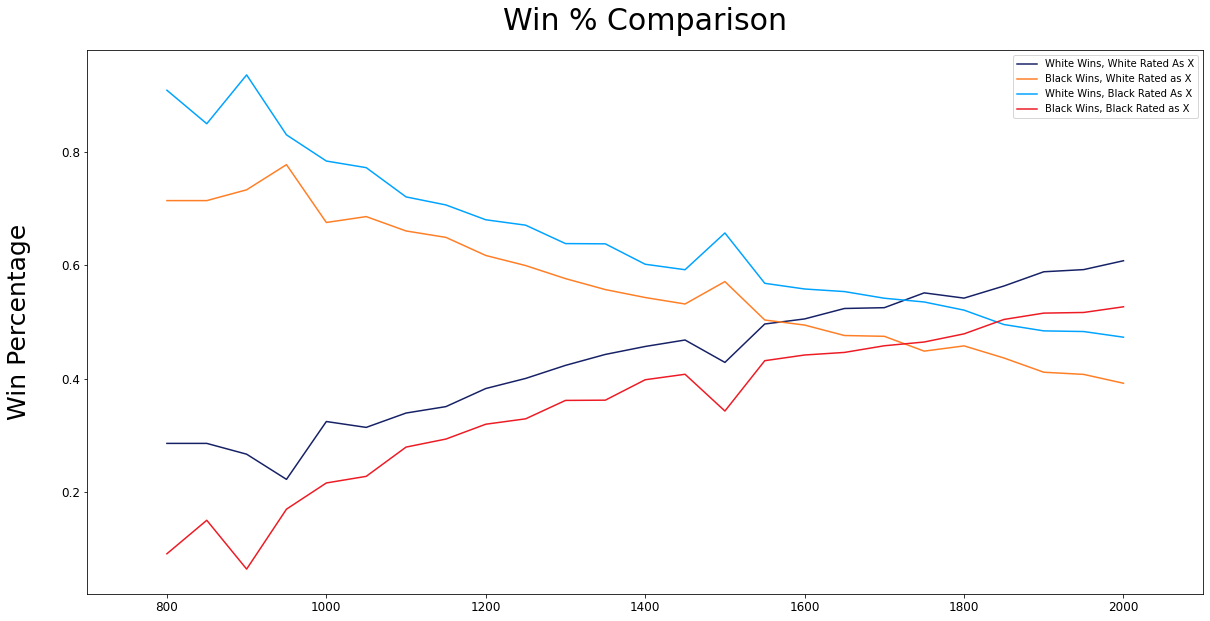

In [59]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)
labels = list(map(int, black_rated_white_win.keys()))


plt.plot(labels, white_rated_white_win.values(), label='White Wins, White Rated As X', color="#162166")
plt.plot(labels, white_rated_black_win.values(), label='Black Wins, White Rated as X', color = '#ff7f26')
plt.plot(labels, black_rated_white_win.values(), label='White Wins, Black Rated As X', color='#00a3ff')
plt.plot(labels, black_rated_black_win.values(), label='Black Wins, Black Rated as X', color='#ed1b24')


plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Win Percentage', fontsize=25, labelpad=30)
plt.title('Win % Comparison', fontsize=30, pad=20)

In [103]:
avg_games_broad = {}

for x in range (800, 2050, 50):
    avg_games_broad[str(x)] = cur.execute(F'''SELECT avg(games)
FROM(
	SELECT count() as games
	FROM games_metadata
	WHERE white_elo = {x}
	Group By white_id)''').fetchone()[0]

Text(0.5, 1.0, 'Average Games Played By Players With One Game at Elo X')

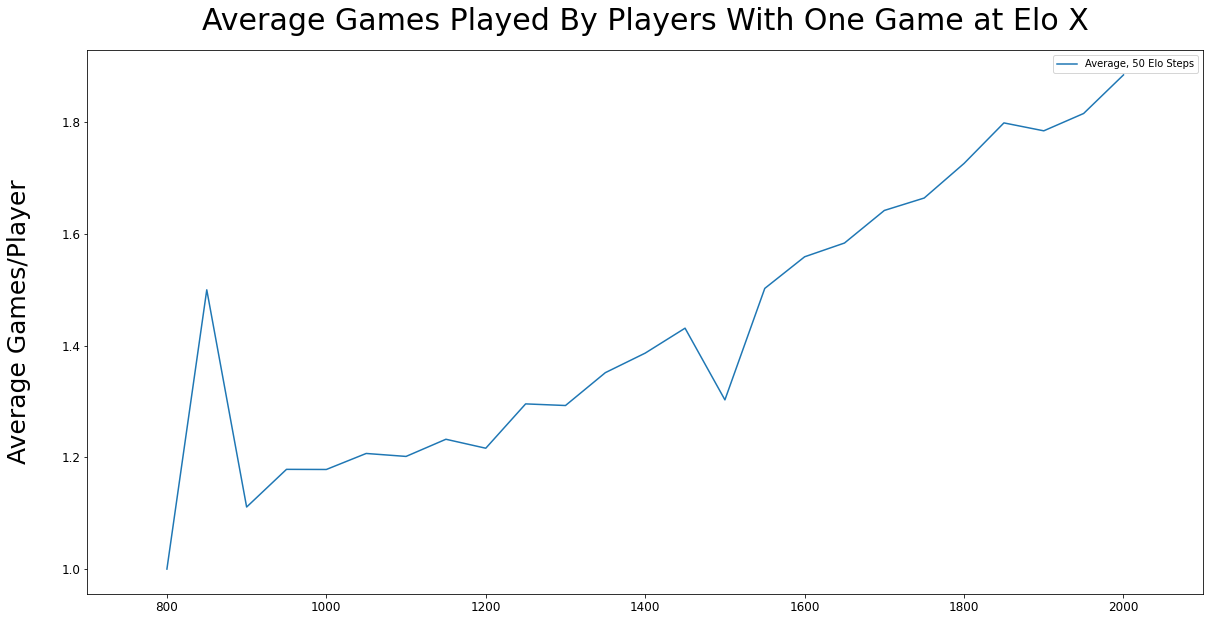

In [114]:
plt.figure(figsize=(20,10))
plt.xlim(left=700, right = 2100)

broad_labels = list(map(int, avg_games_broad.keys()))

plt.plot(broad_labels, avg_games_broad.values(), label='Average, 50 Elo Steps')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Average Games/Player', fontsize=25, labelpad=30)
plt.title('Average Games Played By Players With One Game at Elo X', fontsize=30, pad=20)

In [105]:
avg_games_narrow = {}
for x in range(1490,1511):
    avg_games_narrow[str(x)] = cur.execute(F'''SELECT avg(games)
FROM(
	SELECT count() as games, white_id
	FROM games_metadata
	WHERE white_elo = {x}
	Group By white_id)''').fetchone()[0]

Text(0.5, 1.0, 'Average Games Played, Zoom on 1500')

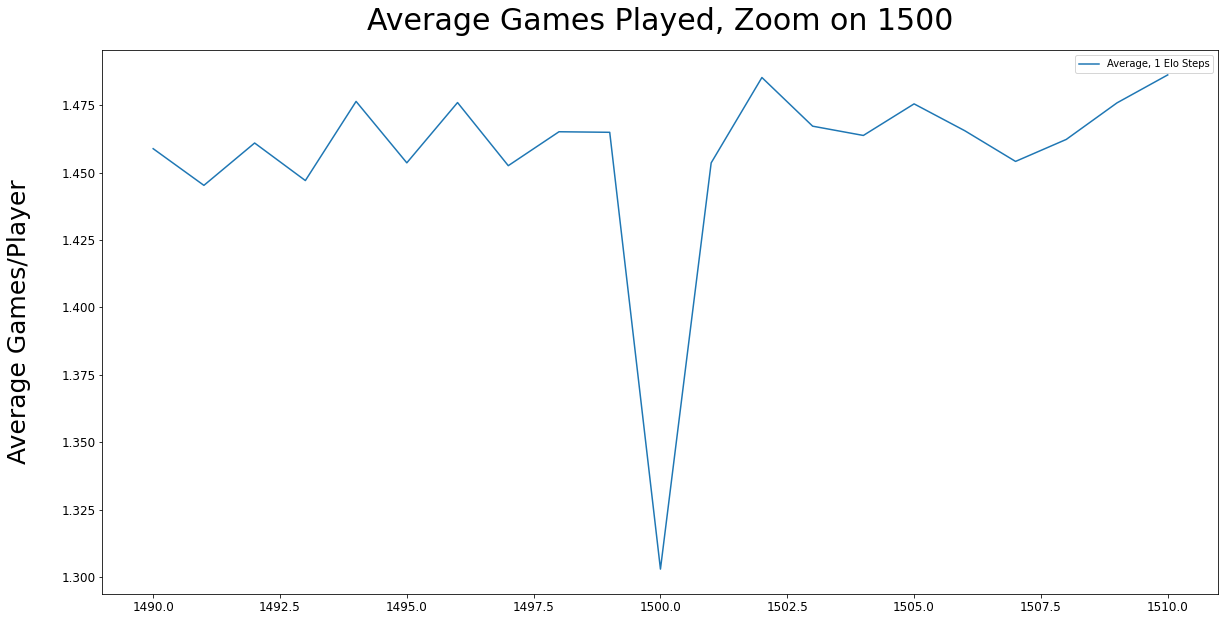

In [115]:
plt.figure(figsize=(20,10))

narrow_labels = list(map(int, avg_games_narrow.keys()))

plt.plot(narrow_labels, avg_games_narrow.values(), label='Average, 1 Elo Steps')
        
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Average Games/Player', fontsize=25, labelpad=30)
plt.title('Average Games Played, Zoom on 1500', fontsize=30, pad=20)

In [46]:
moves = dict((cur.execute('''SELECT number_of_moves, count(game_id)
FROM games_metadata
GROUP BY number_of_moves''')).fetchall())

Text(0.5, 1.0, 'Move Count')

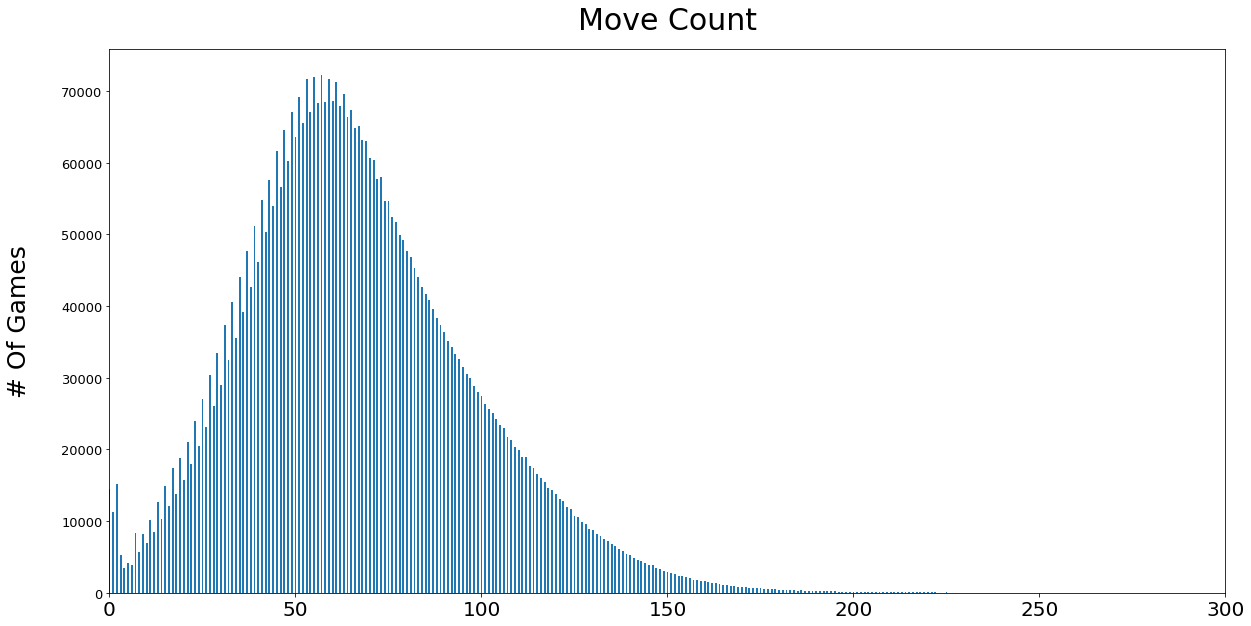

In [4]:
moves_values = list(moves.values())

moves_labels = list(moves.keys())

plt.figure(figsize=(20,10))
plt.bar(x=moves_labels, height= moves_values, width=.5)

plt.xticks(fontsize=20)
plt.xlim(left=0, right=300)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Move Count', fontsize=30, pad=20)


In [40]:
rating_diff = dict(cur.execute('''SELECT ROUND((white_elo - black_elo)/2)*2    AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
GROUP  BY bucket;''').fetchall())

Text(0.5, 1.0, 'ELO Difference')

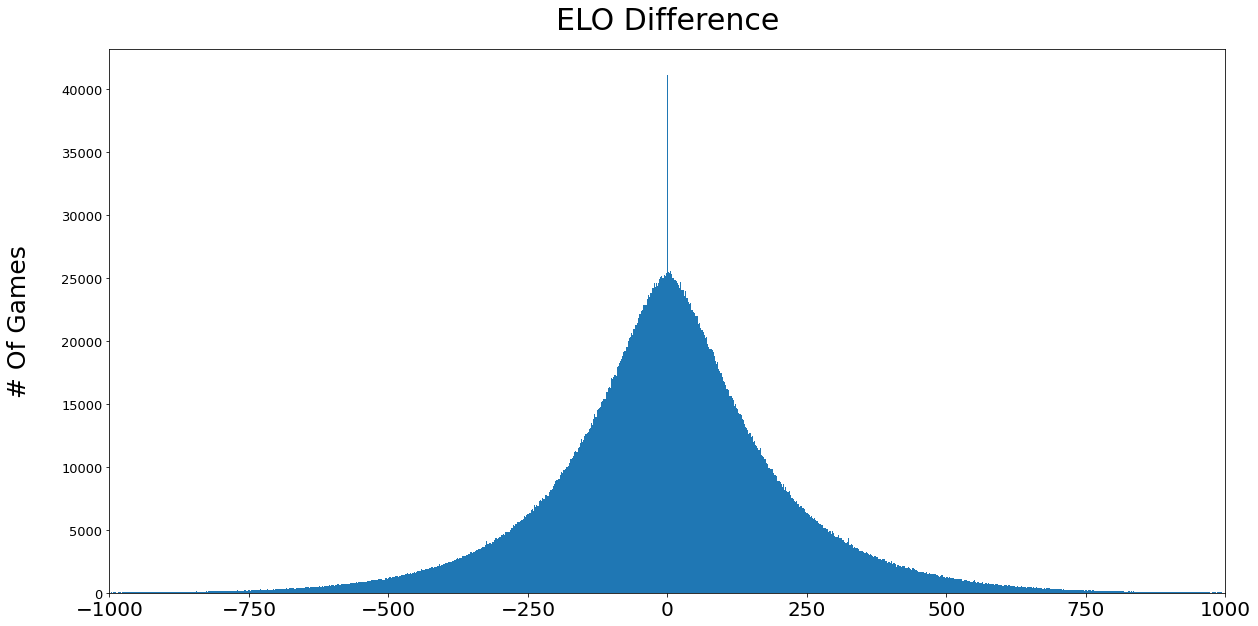

In [41]:
diff_values = list(rating_diff.values())

diff_labels = list(rating_diff.keys())

plt.figure(figsize=(20,10))
plt.bar(x=diff_labels, height= diff_values, width=2)

plt.xticks(fontsize=20)
plt.xlim(left=-1000, right=1000)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('ELO Difference', fontsize=30, pad=20)

In [3]:
diff_dive = dict(cur.execute('''SELECT ROUND((white_elo/10)*10) AS bucket,
       COUNT(game_id)                    AS COUNT
FROM   games_metadata
WHERE white_elo = black_elo
GROUP  BY bucket;''').fetchall())

Text(0.5, 1.0, 'Same ELO Matches')

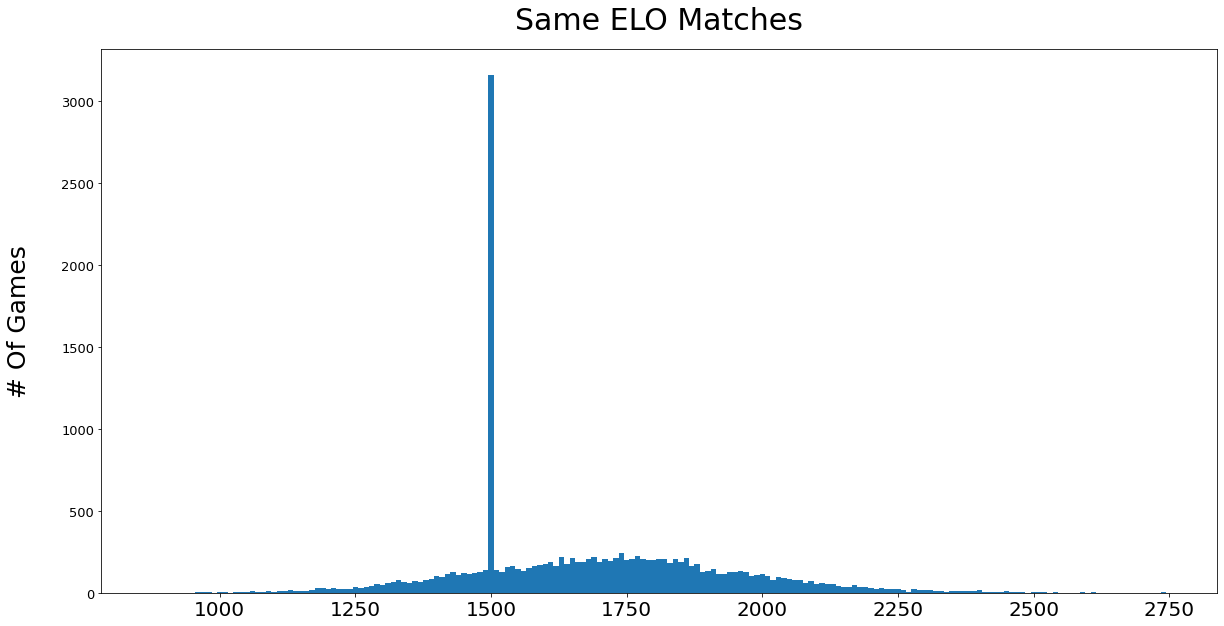

In [4]:
dd_values = list(diff_dive.values())

dd_labels = list(diff_dive.keys())

plt.figure(figsize=(20,10))
plt.bar(x=dd_labels, height= dd_values, width=10)

plt.xticks(fontsize=20)
#plt.xlim(left=0, right=300)

plt.yticks(fontsize=13)
plt.ylabel('# Of Games', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Same ELO Matches', fontsize=30, pad=20)

In [5]:
moves_vs_end = cur.execute('''SELECT 
        number_of_moves, 
        count(CASE WHEN game_end='Normal' THEN 1 END) as Normal_end,
        count(CASE WHEN game_end='Time forfeit' THEN 1 END) as Time_end
    FROM games_metadata
    GROUP BY number_of_moves
    ;''').fetchall()

<AxesSubplot:title={'center':'Length of Game, by End Type'}, xlabel='Moves'>

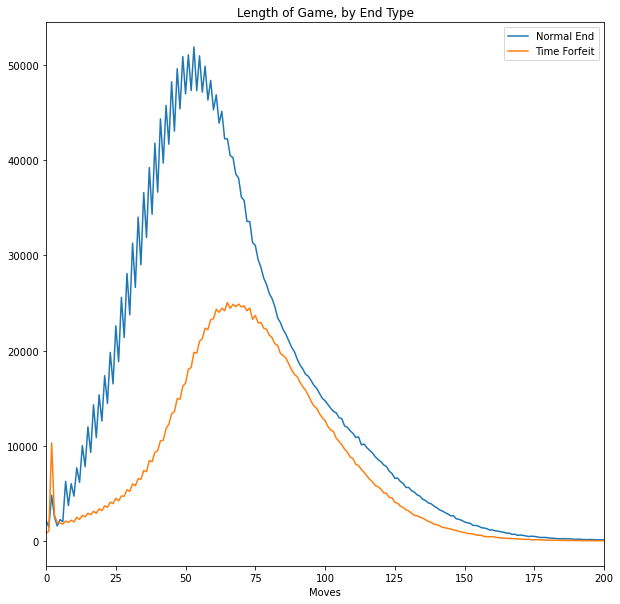

In [6]:
mve_df = pd.DataFrame(moves_vs_end, columns=['Moves', 'Normal End', 'Time Forfeit'])

mve_df.plot(x='Moves', figsize=(10,10), title='Length of Game, by End Type', xlim=(0,200))

# Piece by Piece Analysis

In [5]:
def generate_pieces():
    '''Defines pieces with unique letter/number ID. To be chained with populate_board and make_move_dict'''
    
    nums = []
    for x in range(1,17):
        nums.append(str(x))

    pawns = []
    rooks  = []
    knights = []
    bishops = []
    kings = []
    queens = []

    for x in range(16):
        pawns.append('p'+nums[x])

    for x in range(4):
        rooks.append('r'+nums[x])
        knights.append('n'+nums[x])
        bishops.append('s'+nums[x])

    for x in range(2):
        kings.append('k'+nums[x])
        queens.append('q'+nums[x])
    
    return pawns, rooks, knights, bishops, kings, queens

In [6]:
pawns, rooks, knights, bishops, kings, queens = generate_pieces()

In [103]:
query_list = pawns + rooks + knights + bishops + kings + queens
backrow_query = rooks + knights + bishops + kings + queens

w_backrow = rooks[0:2] + knights[0:2] + bishops[0:2] + [queens[0]] + [kings[0]]
b_backrow = rooks[2:] + knights[2:] + bishops[2:] + [kings[1]] + [queens[1]]

In [40]:
#Dict of dicts to track piece captures
#Top level keys are used to accumulate captures of each piece
#Second level keys will hold counts of how many times the level 2 piece capped the level 1 piece

cap_dict = dict.fromkeys(query_list)
for x in pawns[:8] + w_backrow:
    cap_dict[x] = dict.fromkeys(pawns[8:] + b_backrow)
for x in (pawns[8:] + b_backrow):
    cap_dict[x] = dict.fromkeys(pawns[:8] + w_backrow)

In [64]:
#Piece capping query loop
elos = ['0','2500', '3000', '3500', '4000', '10000']
total_games = 0

for num in range(1,6):
    
    cap_dict = dict.fromkeys(query_list)
    for x in pawns[:8] + w_backrow:
        cap_dict[x] = dict.fromkeys(pawns[8:] + b_backrow)
    for x in (pawns[8:] + b_backrow):
        cap_dict[x] = dict.fromkeys(pawns[:8] + w_backrow)
    
    
    lower = elos[num-1]
    upper = elos[num]
    
    games_num = (len(cur.execute(F'''SELECT p1
            FROM(
                SELECT moves_by_piece.p1
                FROM(
                    SELECT game_id, number_of_moves
                    FROM games_metadata
                    WHERE (games_metadata.elo_sum >= {lower} AND games_metadata.elo_sum <{upper})) AS ELO
                JOIN moves_by_piece
                ON moves_by_piece.game_id = ELO.game_id
                WHERE ELO.number_of_moves > 2);''').fetchall()
                    )
                    )
    
    total_games += games_num
    print(total_games)
    
    for capped_piece in cap_dict.keys():
        print(F'{capped_piece} Batch @ ', dt.datetime.now())

        for capping_piece in cap_dict[capped_piece].keys():
            cap_dict[capped_piece][capping_piece] = (len(cur.execute(F'''SELECT {capped_piece}
            FROM(
                SELECT moves_by_piece.{capped_piece}
                FROM(
                    SELECT game_id, number_of_moves
                    FROM games_metadata
                    WHERE (games_metadata.elo_sum >= {lower} AND games_metadata.elo_sum < {upper})) AS ELO
                JOIN moves_by_piece
                ON moves_by_piece.game_id = ELO.game_id
                WHERE ELO.number_of_moves > 2)
            WHERE {capped_piece} LIKE '%{capping_piece}';''')
                                                         .fetchall()
                                                        ) / games_num
                                                        )
    save = json.dumps(cap_dict)

    with open(F'''query results\cap_dict_elosum_{lower}-{upper}.txt''', 'w') as new_file:
        new_file.write(save)
        
    cap_dict.clear()
    print(total_games)

138200
p1 Batch @  2021-07-09 06:40:45.892683
p2 Batch @  2021-07-09 06:41:52.920007
p3 Batch @  2021-07-09 06:42:59.758623
p4 Batch @  2021-07-09 06:44:07.192559
p5 Batch @  2021-07-09 06:45:14.638723
p6 Batch @  2021-07-09 06:46:22.328877
p7 Batch @  2021-07-09 06:47:29.799303
p8 Batch @  2021-07-09 06:48:36.874423
p9 Batch @  2021-07-09 06:49:43.900926
p10 Batch @  2021-07-09 06:50:50.955294
p11 Batch @  2021-07-09 06:51:58.045667
p12 Batch @  2021-07-09 06:53:05.017915
p13 Batch @  2021-07-09 06:54:12.180527
p14 Batch @  2021-07-09 06:55:19.297553
p15 Batch @  2021-07-09 06:56:27.625163
p16 Batch @  2021-07-09 06:57:34.640873
r1 Batch @  2021-07-09 06:58:41.520727
r2 Batch @  2021-07-09 06:59:48.514241
r3 Batch @  2021-07-09 07:00:55.567191
r4 Batch @  2021-07-09 07:02:02.624879
n1 Batch @  2021-07-09 07:03:09.629245
n2 Batch @  2021-07-09 07:04:17.132198
n3 Batch @  2021-07-09 07:05:24.483216
n4 Batch @  2021-07-09 07:06:32.296053
s1 Batch @  2021-07-09 07:07:39.596349
s2 Batch @ 

In [6]:
w_elo_by_id = dict(cur.execute('''SELECT round(average/10)*10 AS bucket,
	count(white_id)
FROM(
	SELECT round(avg(white_elo)) as average, white_id
	FROM games_metadata
	GROUP BY white_id
	ORDER BY average DESC)
GROUP BY bucket;''').fetchall())

b_elo_by_id = dict(cur.execute('''SELECT round(average/10)*10 AS bucket,
	count(black_id)
FROM(
	SELECT round(avg(black_elo)) as average, black_id
	FROM games_metadata
	GROUP BY black_id
	ORDER BY average DESC)
GROUP BY bucket;''').fetchall())


Text(0.5, 1.0, 'White Player Ratings')

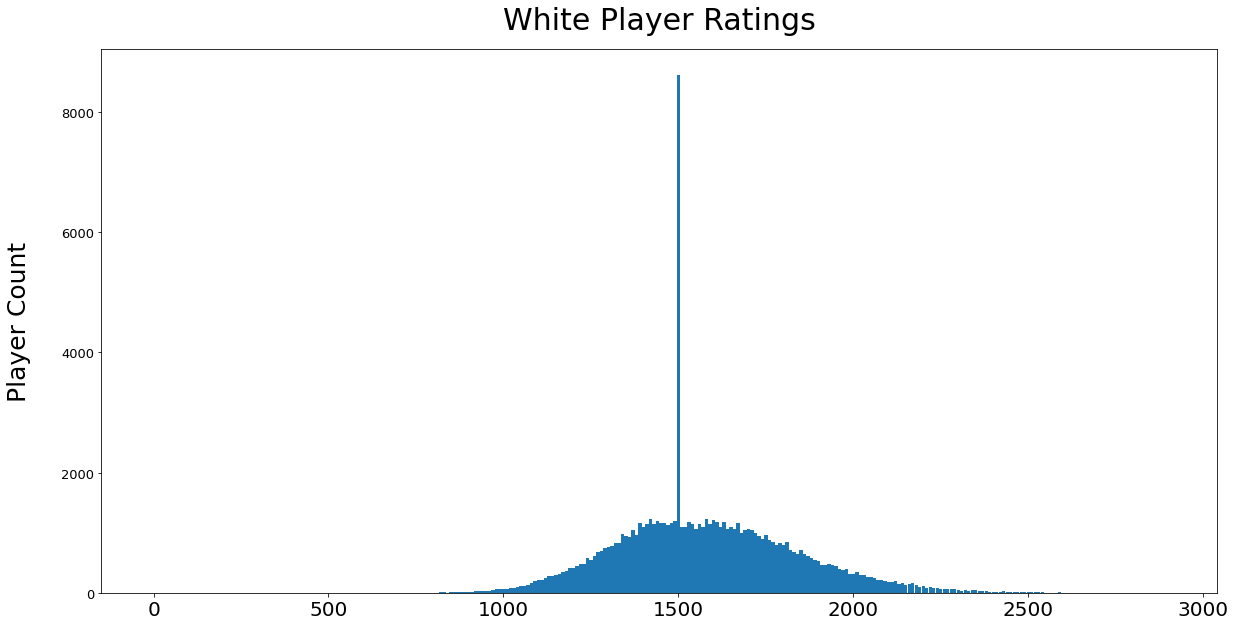

In [7]:
elo_id_values = list(w_elo_by_id.values())
elo_id_labels = list(w_elo_by_id.keys())

plt.figure(figsize=(20,10))
plt.bar(x=elo_id_labels, height= elo_id_values, width=9)

plt.xticks(fontsize=20)

plt.yticks(fontsize=13)
plt.ylabel('Player Count', fontsize=25, labelpad=30)

plt.ticklabel_format(style='plain', axis='y')
plt.title('White Player Ratings', fontsize=30, pad=20)

In [94]:
check = pd.Series(cur.execute(F'''SELECT count() as games
    FROM games_metadata
    WHERE white_elo = 1490
    Group By white_id''').fetchall())

In [46]:
def create_board():
    '''Creates dictionary representing chess board, using standard square notation for ease of understanding'''
    
    board = {}
    for num in '12345678':
        for letter in 'abcdefgh':
            key = letter + num
            board[key]  = []
    
    return board


In [48]:
elos = ['0','2500', '3000', '3500', '4000', '10000']

death_dict = dict.fromkeys(query_list)
board = create_board()

for piece in query_list:
    death_dict[piece] = dict(zip(board.keys(),([0]*64)))
    
query_list.remove('k1')
query_list.remove('k2')

for piece in query_list:
    
    #Don't need to filter by number of moves, pieces can't be capped in the first 2 turns
    results = pd.Series(cur.execute(F'''SELECT {piece}
        FROM moves_by_piece
        WHERE length({piece}) >1 AND 
        substr({piece},-2,1) NOT IN ('a','b','c','d','e','f','g','h');''').fetchall())
    
    #Results currently holds tuples with length = 1. This extracts the results string
    results = results.apply(lambda x:x[0])
    
    #Catching and eliminating promoted pawns
    if 'p' in piece:
        promoted = results[results.str.contains('P', regex=False)] #Isolate promoted pawns
        promoted = promoted.str.split('P\w\/') #Split all strings at the promotion entry
        promoted = promoted.apply(lambda x: x[0] + x[1][:5]) #Add square the pawn was promoted on to rest of move history
                                                        #One extra move is added for easier integration with rest of function
        results.update(promoted)
        
        
    #Split each string in the series, return the square the piece died on, then tally and make dict
    results = dict(results.str.split('/').apply(lambda x: x[-2]).value_counts())
    
    
    death_dict[piece].update(results)
    print(F'{piece} completed at {dt.datetime.now()}')
                        

p1 completed at 2021-07-26 09:25:52.875720
p2 completed at 2021-07-26 09:26:04.582609
p3 completed at 2021-07-26 09:26:19.605002
p4 completed at 2021-07-26 09:26:37.233054
p5 completed at 2021-07-26 09:26:55.587458
p6 completed at 2021-07-26 09:27:08.594204
p7 completed at 2021-07-26 09:27:19.877052
p8 completed at 2021-07-26 09:27:30.027478
p9 completed at 2021-07-26 09:27:40.484856
p10 completed at 2021-07-26 09:27:52.201998
p11 completed at 2021-07-26 09:28:05.221212
p12 completed at 2021-07-26 09:28:22.472793
p13 completed at 2021-07-26 09:28:40.389551
p14 completed at 2021-07-26 09:28:56.154467
p15 completed at 2021-07-26 09:29:08.788067
p16 completed at 2021-07-26 09:29:19.516533
r1 completed at 2021-07-26 09:29:33.004998
r2 completed at 2021-07-26 09:29:47.765431
r3 completed at 2021-07-26 09:30:02.265228
r4 completed at 2021-07-26 09:30:16.264591
n1 completed at 2021-07-26 09:30:36.123797
n2 completed at 2021-07-26 09:30:55.680490
n3 completed at 2021-07-26 09:31:16.185319
n4 c

In [38]:
results = pd.Series(cur.execute(F'''SELECT p1
        FROM moves_by_piece
        WHERE length(p1) >1 AND 
        substr(p1,-2,1) NOT IN ('a','b','c','d','e','f','g','h');''').fetchall())

results = results.apply(lambda x:x[0])

In [142]:
query_list = pawns + rooks + bishops + knights + queens + kings
death_dict = dict.fromkeys(query_list)
board = create_board()

for piece in query_list:
    death_dict[piece] = dict(zip(board.keys(),([0]*64)))

results = pd.DataFrame(cur.execute(F'''SELECT moves_by_piece.*
    FROM moves_by_piece	
    INNER JOIN games_metadata
    ON moves_by_piece.game_id = games_metadata.game_id
    WHERE games_metadata.number_of_moves > 2;'''))
print('Query done')

columns_dict = dict(zip(results.columns, ['game_id']+query_list))
results.rename(columns=columns_dict, inplace=True)

query_list.remove('k1')
query_list.remove('k2')

for piece in query_list:

    sub = results[piece][results[piece].apply(lambda x: len(x)) > 2]
    new_sub = sub[~sub.apply(lambda x: x[-2] in ('a','b','c','d','e','f','g','h'))]

    #Catching and dealing with promoted pawns
    if 'p' in piece:
        promoted = new_sub[new_sub.str.contains('P', regex=False)] #Isolate promoted pawns
        promoted = promoted.str.split('P\w\/') #Split all strings at the promotion entry
        promoted = promoted.apply(lambda x: x[0] + x[1][:5])

        new_sub.update(promoted)


    #Split each string in the series, return the square the piece died on, then tally and make dict
    data = dict(new_sub.str.split('/').apply(lambda x: x[-2]).value_counts().astype(float))
    del(sub)
    del(new_sub)

    death_dict[piece].update(data)
    print(F'{piece} completed at {dt.datetime.now()}')


save = json.dumps(death_dict)

with open(F'''query results\death_dict.txt''', 'w') as new_file:
    new_file.write(save)

Query done
p1 completed at 2021-07-26 17:18:13.783956
p2 completed at 2021-07-26 17:18:24.105813
p3 completed at 2021-07-26 17:18:36.864390
p4 completed at 2021-07-26 17:18:52.442247
p5 completed at 2021-07-26 17:19:08.327686
p6 completed at 2021-07-26 17:19:19.864241
p7 completed at 2021-07-26 17:19:28.907013
p8 completed at 2021-07-26 17:19:37.734729
p9 completed at 2021-07-26 17:19:46.691867
p10 completed at 2021-07-26 17:19:56.273155
p11 completed at 2021-07-26 17:20:07.458731
p12 completed at 2021-07-26 17:20:22.284873
p13 completed at 2021-07-26 17:20:38.047974
p14 completed at 2021-07-26 17:20:50.727158
p15 completed at 2021-07-26 17:21:01.072517
p16 completed at 2021-07-26 17:21:09.608065
r1 completed at 2021-07-26 17:21:20.021674
r2 completed at 2021-07-26 17:21:32.080570
r3 completed at 2021-07-26 17:21:43.476794
r4 completed at 2021-07-26 17:21:54.580077
s1 completed at 2021-07-26 17:22:09.160336
s2 completed at 2021-07-26 17:22:22.758517
s3 completed at 2021-07-26 17:22:37.

In [139]:
#Piece death query loop
elos = ['0','2500', '3000', '3500', '4000', '10000']

for num in range(1,6):
    
    lower = elos[num-1]
    upper = elos[num]
    
    query_list = pawns + rooks + bishops + knights + queens + kings
    death_dict = dict.fromkeys(query_list)
    board = create_board()

    for piece in query_list:
        death_dict[piece] = dict(zip(board.keys(),([0]*64)))

    results = pd.DataFrame(cur.execute(F'''SELECT moves_by_piece.*
    FROM moves_by_piece	
    INNER JOIN games_metadata
    ON moves_by_piece.game_id = games_metadata.game_id
    WHERE games_metadata.number_of_moves > 2 AND
        games_metadata.elo_sum >= {lower} AND 
        games_metadata.elo_sum <{upper} ;'''))

    columns_dict = dict(zip(results.columns, ['game_id']+query_list))
    results.rename(columns=columns_dict, inplace=True)
    
    query_list.remove('k1')
    query_list.remove('k2')
    
    for piece in query_list:

        sub = results[piece][results[piece].apply(lambda x: len(x)) > 2]
        new_sub = sub[~sub.apply(lambda x: x[-2] in ('a','b','c','d','e','f','g','h'))]

        #Catching and dealing with promoted pawns
        if 'p' in piece:
            promoted = new_sub[new_sub.str.contains('P', regex=False)] #Isolate promoted pawns
            promoted = promoted.str.split('P\w\/') #Split all strings at the promotion entry
            promoted = promoted.apply(lambda x: x[0] + x[1][:5])

            new_sub.update(promoted)


        #Split each string in the series, return the square the piece died on, then tally and make dict
        data = dict(new_sub.str.split('/').apply(lambda x: x[-2]).value_counts().astype(float))
        del(sub)
        del(new_sub)

        death_dict[piece].update(data)
        del(data)
        print(F'{piece} completed at {dt.datetime.now()}')
        
    del(results)
    
    save = json.dumps(death_dict)

    with open(F'''query results\death_dict_elosum_{lower}-{upper}.txt''', 'w') as new_file:
        new_file.write(save)

p1 completed at 2021-07-26 15:32:37.800235
p2 completed at 2021-07-26 15:32:38.014038
p3 completed at 2021-07-26 15:32:38.491593
p4 completed at 2021-07-26 15:32:38.969148
p5 completed at 2021-07-26 15:32:39.480671
p6 completed at 2021-07-26 15:32:39.783389
p7 completed at 2021-07-26 15:32:40.103091
p8 completed at 2021-07-26 15:32:40.329880
p9 completed at 2021-07-26 15:32:40.623604
p10 completed at 2021-07-26 15:32:40.903830
p11 completed at 2021-07-26 15:32:41.321860
p12 completed at 2021-07-26 15:32:41.830388
p13 completed at 2021-07-26 15:32:42.237009
p14 completed at 2021-07-26 15:32:42.630650
p15 completed at 2021-07-26 15:32:43.001318
p16 completed at 2021-07-26 15:32:43.235128
r1 completed at 2021-07-26 15:32:43.621032
r2 completed at 2021-07-26 15:32:43.930564
r3 completed at 2021-07-26 15:32:44.332190
r4 completed at 2021-07-26 15:32:44.625917
s1 completed at 2021-07-26 15:32:45.076497
s2 completed at 2021-07-26 15:32:45.540065
s3 completed at 2021-07-26 15:32:45.997638
s4 c

In [144]:
save = json.dumps(death_dict)

with open(F'''query results\death_dict.txt''', 'w') as new_file:
    new_file.write(save)